In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
folders = os.listdir('/content/drive/MyDrive/eye disease detection/split_dataset/train')

In [ ]:
folders

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [ ]:
path = '/content/drive/MyDrive/eye disease detection/split_dataset/train/'
for i in folders:
  print(i, len(os.listdir(path+i)))

cataract 726
diabetic_retinopathy 768
glaucoma 704
normal 751


In [ ]:
import keras.utils as image
import matplotlib.pyplot as plt

In [ ]:
img = image.load_img('/content/drive/MyDrive/eye disease detection/split_dataset/test/diabetic_retinopathy/10042_left.jpeg')

In [ ]:
print(type(img))

<class 'PIL.JpegImagePlugin.JpegImageFile'>


In [ ]:
img = image.img_to_array(img)/255

In [ ]:
img.shape

(512, 512, 3)

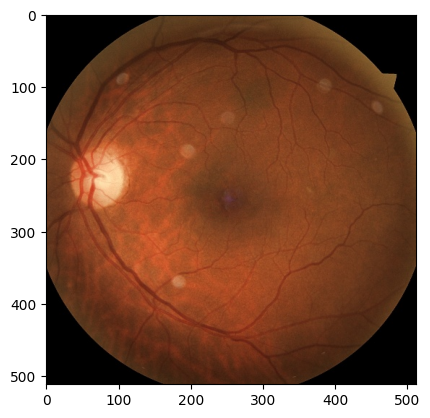

In [ ]:
plt.imshow(img)
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_set = ImageDataGenerator(
    rescale = 1/255,
    rotation_range = 40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=0.2,
    shear_range=0.2,
    zoom_range=0.2
)
valid_set = ImageDataGenerator(rescale=1/255)

In [ ]:
train_gen = train_set.flow_from_directory(path,
                                         target_size = (224, 224),
                                         batch_size = 32,
                                         class_mode = 'categorical')


val_path = '/content/drive/MyDrive/eye disease detection/split_dataset/val'
val_generator = valid_set.flow_from_directory(
    val_path,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 2949 images belonging to 4 classes.
Found 637 images belonging to 4 classes.


In [ ]:
for i, j in train_gen:
    print(i.shape, j.shape)
    break

(32, 224, 224, 3) (32, 4)


[0. 1. 0. 0.]


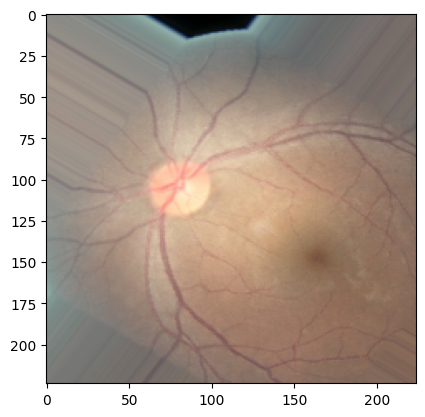

In [ ]:
plt.imshow(i[18])
print(j[18])

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import numpy as np

In [ ]:
base_model = ResNet50(weights='imagenet', include_top = False, input_shape = (224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

In [ ]:
output = base_model.output
output = GlobalAveragePooling2D()(output)
output = Dropout(0.3)(output)
output = Dense(4, activation = 'softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(output)

In [ ]:
model = Model(inputs = base_model.input, outputs = output)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 23,542,788 (89.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
import tensorflow as tf
from tensorflow.keras import optimizers
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
hist = model.fit(train_gen, epochs = 25, validation_data = val_generator)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 1152s 11s/step - accuracy: 0.5761 - loss: 1.3364 - val_accuracy: 0.2465 - val_loss: 1.6670
Epoch 2/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 116s 743ms/step - accuracy: 0.7272 - loss: 0.8133 - val_accuracy: 0.2465 - val_loss: 14.1571
Epoch 3/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 74s 750ms/step - accuracy: 0.7714 - loss: 0.6555 - val_accuracy: 0.2465 - val_loss: 5.4630
Epoch 4/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 78s 784ms/step - accuracy: 0.7777 - loss: 0.6804 - val_accuracy: 0.2465 - val_loss: 3.9856
Epoch 5/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 73s 740ms/step - accuracy: 0.7715 - loss: 0.6174 - val_accuracy: 0.2480 - val_loss: 2.9129
Epoch 6/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 75s 751ms/step - accuracy: 0.8100 - loss: 0.5356 - val_accuracy: 0.1821 - val_loss: 3.0293
Epoch 7/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 74s 748ms/step - accuracy: 0.8272 - loss: 0.4818 - val_accuracy: 0.2512 - val_loss: 5.2565
Epoch 8/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 83s 741ms/step - accuracy: 0.8687 - loss: 0.4276 - val_accuracy: 0.4

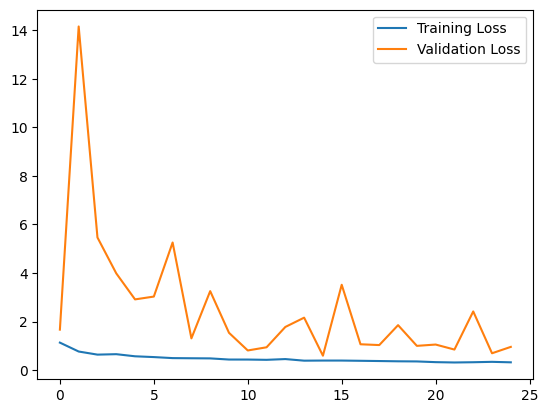

In [ ]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

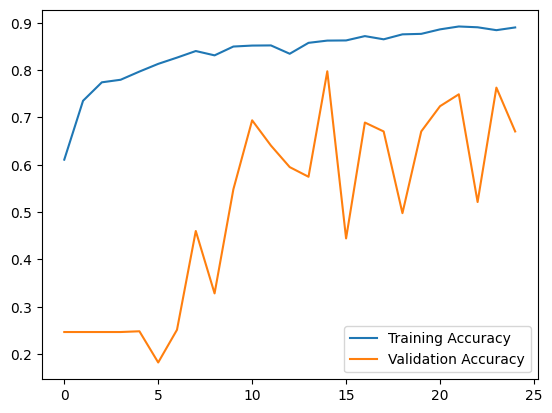

In [ ]:
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_set = ImageDataGenerator(rescale=1/255)
test_path = '/content/drive/MyDrive/eye disease detection/split_dataset/test'

test_gen = test_set.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 631 images belonging to 4 classes.


In [ ]:
test_loss, test_accuracy = model.evaluate(test_gen)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 184s 10s/step - accuracy: 0.6757 - loss: 0.9476
Test Accuracy: 66.09%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

Y_pred = model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_gen.classes

report = classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys())
print(report)


20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 475ms/step
                      precision    recall  f1-score   support

            cataract       0.89      0.81      0.85       155
diabetic_retinopathy       0.98      0.54      0.70       164
            glaucoma       0.80      0.28      0.42       151
              normal       0.46      0.99      0.63       161

            accuracy                           0.66       631
           macro avg       0.78      0.66      0.65       631
        weighted avg       0.78      0.66      0.65       631



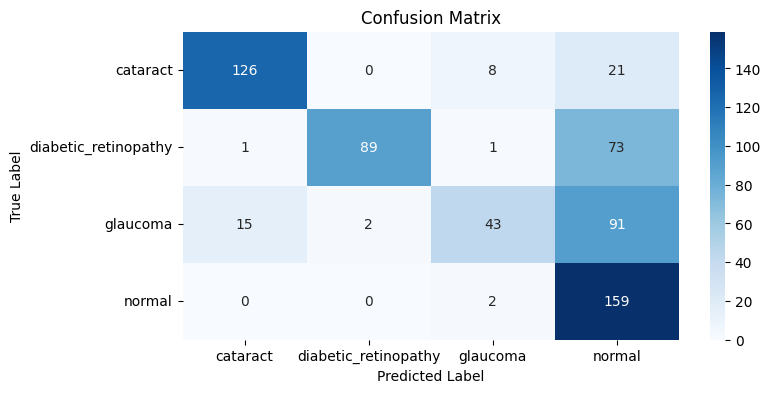

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
